<a href="https://colab.research.google.com/github/monicasjsu/Emerging-Software-Technologies/blob/master/Assignment_1_Part_2/SemiSupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi Supervised Learning on Credit Card Dataset

We use semi supervised leanring when we have a small amount of labeled data and large amounts of unlabeled dataset.


In [28]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import lightgbm as lgb

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy


In [2]:
from google.colab import drive
data = pd.read_csv("/content/drive/My Drive/Datasets/creditcard.csv")

In [3]:
x_data = data.copy().drop(['Class','Time'],axis=1)
y_data = data['Class'].copy()

In [4]:
scaleFeatures = x_data.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
x_data.loc[:,scaleFeatures] = sX.fit_transform(x_data[scaleFeatures])


X_train, X_test, y_train, y_test = \
    train_test_split(x_data, y_data, test_size=0.33,random_state=2018, stratify=y_data)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(190820, 29)
(93987, 29)
(190820,)
(93987,)


In [6]:
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [8]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [9]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [10]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [11]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [12]:
trainingScore = []
scorey = []
KFoldPrediction = pd.DataFrame(data=[], index=y_train.index, columns=['prediction'])

for trainindex, cvindex in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    # get x_data based on the stratified k fold indices 
    xtrainfold, xcvfold = X_train.iloc[trainindex,:], X_train.iloc[cvindex,:]
    # get y_data based on the stratified k fold indices 
    ytrainfold, ycvfold = y_train.iloc[trainindex],   y_train.iloc[cvindex]
    
    # gradient boost the training data using LightGBM
    lgbtrain = lgb.Dataset(xtrainfold, ytrainfold)
    lgbeval = lgb.Dataset(xcvfold, ycvfold, reference=lgbtrain)


    gbm = lgb.train(params_lightGB, lgbtrain, num_boost_round=2000,valid_sets=lgbeval, early_stopping_rounds=200)
    
    # calculate the log loss on the train dataset 
    loglossTraining = log_loss(ytrainfold, gbm.predict(xtrainfold, num_iteration=gbm.best_iteration))
    trainingScore.append(loglossTraining)
    
    # store the predictions 
    KFoldPrediction.loc[xcvfold.index,'prediction'] = gbm.predict(xcvfold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(ycvfold, KFoldPrediction.loc[xcvfold.index,'prediction'])
    scorey.append(loglossCV)
  
    print(f'Training Log Loss: {loglossTraining}')
    print(f'Label Log Loss: {loglossCV}')

[1]	valid_0's binary_logloss: 0.00328814
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00501798
[3]	valid_0's binary_logloss: 0.0113596
[4]	valid_0's binary_logloss: 0.0134411
[5]	valid_0's binary_logloss: 0.0120885
[6]	valid_0's binary_logloss: 0.0118795
[7]	valid_0's binary_logloss: 0.0123715
[8]	valid_0's binary_logloss: 0.0112126
[9]	valid_0's binary_logloss: 0.0111943
[10]	valid_0's binary_logloss: 0.0110223
[11]	valid_0's binary_logloss: 0.0119001
[12]	valid_0's binary_logloss: 0.011144
[13]	valid_0's binary_logloss: 0.0108834
[14]	valid_0's binary_logloss: 0.0103315
[15]	valid_0's binary_logloss: 0.010241
[16]	valid_0's binary_logloss: 0.0102127
[17]	valid_0's binary_logloss: 0.0101784
[18]	valid_0's binary_logloss: 0.0101528
[19]	valid_0's binary_logloss: 0.0103359
[20]	valid_0's binary_logloss: 0.0103066
[21]	valid_0's binary_logloss: 0.010272
[22]	valid_0's binary_logloss: 0.0102553
[23]	valid_0's binary_logloss: 0.0102284
[24]

Calculate the log loss using the LightGBM

In [13]:
lightGBMGradientBoostinglogloss = log_loss(y_train, 
        KFoldPrediction.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(lightGBMGradientBoostinglogloss,4)}')


LightGBM Gradient Boosting Log Loss: 0.0024


Plot the precision recall curve and ROC curve on training data

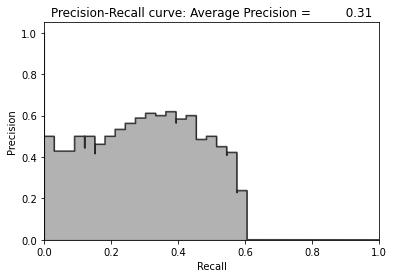

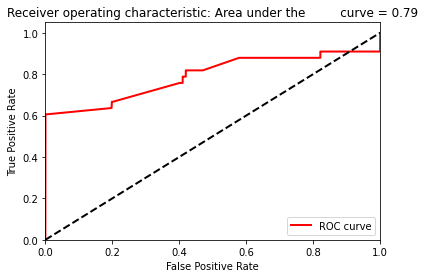

In [14]:
preds, averageprecision = plotResults(y_train, KFoldPrediction.loc[:,'prediction'], True)

Plot the precision recall curve and ROC curve on test data

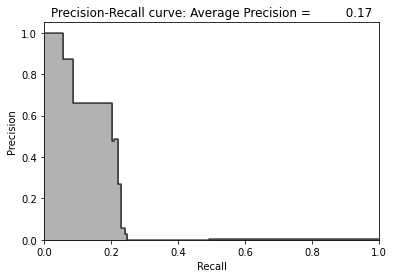

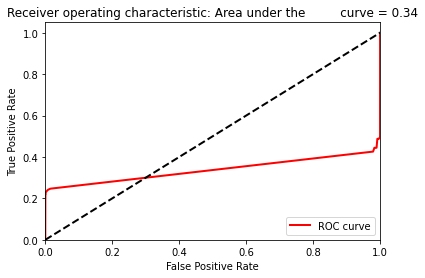

In [15]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, averageprecision = plotResults(y_test, predictions, True)


In [16]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'recall {round(precision,4)}')

recall 0.0013


Oversample the data

In [17]:
oversamplemultiplier = 100

Xtrain_original = X_train.copy()
ytrain_original = y_train.copy()
Xtest_original = X_test.copy()
ytest_original = y_test.copy()


Xtrain_oversamp = X_train.copy()
ytrain_oversamp = y_train.copy()
Xtrain_oversamp = Xtrain_oversamp.append(  [Xtrain_oversamp[y_train==1]]*oversamplemultiplier,  ignore_index=False)
ytrain_oversamp = ytrain_oversamp.append( [ytrain_oversamp[y_train==1]]*oversamplemultiplier,  ignore_index=False)

X_train = Xtrain_oversamp.copy()
y_train = ytrain_oversamp.copy()

In [18]:
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(1e-4),input_dim=29, name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [19]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


In [20]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/5
4846/4846 [==============================] - 7s 1ms/step - loss: 0.0904 - accuracy: 0.8557 - val_loss: 0.0123 - val_accuracy: 0.9802
Epoch 2/5
4846/4846 [==============================] - 7s 1ms/step - loss: 0.0184 - accuracy: 0.9257 - val_loss: 0.0387 - val_accuracy: 0.9725
Epoch 3/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0176 - accuracy: 0.9271 - val_loss: 0.0675 - val_accuracy: 0.9685
Epoch 4/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0181 - accuracy: 0.9274 - val_loss: 0.0159 - val_accuracy: 0.9805
Epoch 5/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0172 - accuracy: 0.9283 - val_loss: 0.0169 - val_accuracy: 0.9782


5954/5954 [==============================] - 4s 685us/step


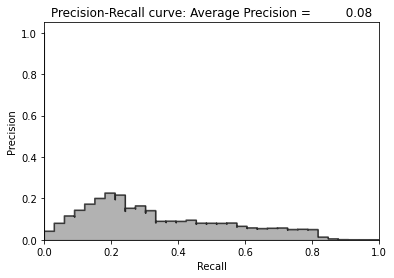

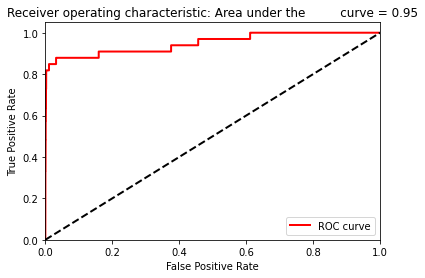

In [21]:
predictionsTrain = model.predict(Xtrain_original, verbose=1)
anomalyScoresAETrain = anomalyScores(Xtrain_original, predictionsTrain)
preds, average_precision = plotResults(ytrain_original, anomalyScoresAETrain, True)

2938/2938 [==============================] - 2s 710us/step


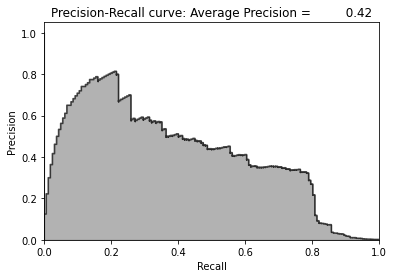

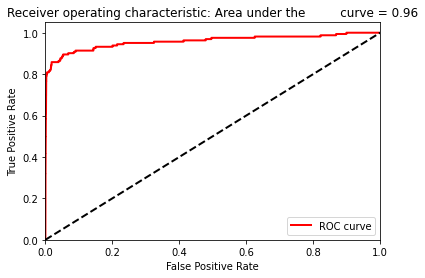

In [22]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [23]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.33884297520661155


Semi Supervised Learning

In [24]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

intermediate_output_train = intermediate_layer_model.predict(Xtrain_original)

intermediate_output_test = intermediate_layer_model.predict(Xtest_original)


In [25]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=Xtrain_original.index)

intermediate_output_testDF = pd.DataFrame(data=intermediate_output_test,index=Xtest_original.index)

In [26]:
X_train = Xtrain_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)

X_test = Xtest_original.merge(intermediate_output_testDF, left_index=True,right_index=True)

y_train = ytrain_original.copy()

In [30]:
# trainingScores = []
# cvScores = []
# predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
#                                         columns=['prediction'])

# for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
#                                           y_train.ravel()):
#     X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
#         X_train.iloc[cv_index,:]
#     y_train_fold, y_cv_fold = y_train.iloc[train_index], \
#         y_train.iloc[cv_index]
    
#     lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
#     lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
#     gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
#                    valid_sets=lgb_eval, early_stopping_rounds=200)
    
#     loglossTraining = log_loss(y_train_fold, 
#                                 gbm.predict(X_train_fold, \
#                                 num_iteration=gbm.best_iteration))
#     trainingScores.append(loglossTraining)
    
#     predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
#         gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
#     loglossCV = log_loss(y_cv_fold, \
#             predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
#     cvScores.append(loglossCV)
    
#     print('Training Log Loss: ', loglossTraining)
#     print('CV Log Loss: ', loglossCV)
    
# loglossLightGBMGradientBoosting = log_loss(y_train, \
#                         predictionsBasedOnKFolds.loc[:,'prediction'])
# print('LightGBM Gradient Boosting Log Loss: ', \
#                         loglossLightGBMGradientBoosting)


trainingScore = []
scorey = []
KFoldPrediction = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for trainindex, cvindex in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    # get x values from the stratified dataset 
    xtrainfold, xcvfold = X_train.iloc[trainindex,:], X_train.iloc[cvindex,:]

    # get y values from the stratified dataset 
    ytrainfold, ycvfold = y_train.iloc[trainindex], y_train.iloc[cvindex]
    
    # using LightGBM, get training and evaluation dataset 
    lgbtrain = lgb.Dataset(xtrainfold, ytrainfold)
    lgbeval = lgb.Dataset(xcvfold, ycvfold, reference=lgbtrain)
    gbm = lgb.train(params_lightGB, lgbtrain, num_boost_round=5000,valid_sets=lgbeval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(ytrainfold, gbm.predict(xtrainfold,num_iteration=gbm.best_iteration))
    trainingScore.append(loglossTraining)
    
    KFoldPrediction.loc[xcvfold.index,'prediction'] = gbm.predict(xcvfold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(ycvfold, KFoldPrediction.loc[xcvfold.index,'prediction'])
    scorey.append(loglossCV)
    
    print(f'Log Loss - Training: {round(loglossTraining,4)}')
    print(f'Log Loss - CV: {round(loglossCV,4)}' )

[1]	valid_0's binary_logloss: 0.00423768
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00527968
[3]	valid_0's binary_logloss: 0.00593652
[4]	valid_0's binary_logloss: 0.00596756
[5]	valid_0's binary_logloss: 0.00601316
[6]	valid_0's binary_logloss: 0.00584299
[7]	valid_0's binary_logloss: 0.00567483
[8]	valid_0's binary_logloss: 0.00563357
[9]	valid_0's binary_logloss: 0.00559858
[10]	valid_0's binary_logloss: 0.0055686
[11]	valid_0's binary_logloss: 0.00552762
[12]	valid_0's binary_logloss: 0.00549194
[13]	valid_0's binary_logloss: 0.00546219
[14]	valid_0's binary_logloss: 0.00543381
[15]	valid_0's binary_logloss: 0.00527473
[16]	valid_0's binary_logloss: 0.0052502
[17]	valid_0's binary_logloss: 0.00522691
[18]	valid_0's binary_logloss: 0.00520794
[19]	valid_0's binary_logloss: 0.00519011
[20]	valid_0's binary_logloss: 0.00508899
[21]	valid_0's binary_logloss: 0.0050731
[22]	valid_0's binary_logloss: 0.0050538
[23]	valid_0's binary_logl

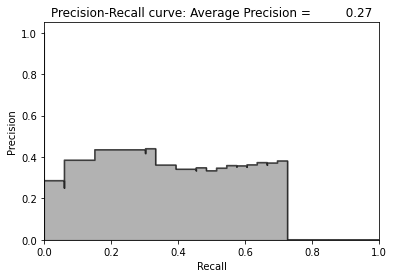

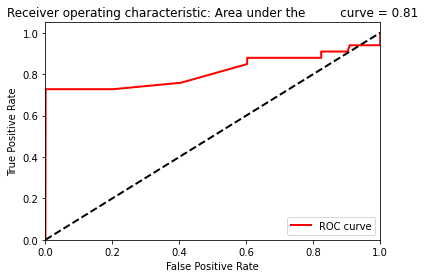

In [32]:
preds, average_precision = plotResults(y_train, \
                        KFoldPrediction.loc[:,'prediction'], True)

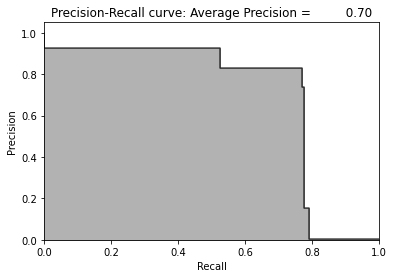

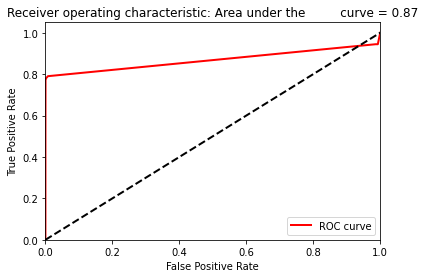

In [33]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)

preds, average_precision = plotResults(y_test, predictions, True)

In [34]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.8424657534246576


In [35]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])

featuresImportance = featuresImportance/featuresImportance.sum()

featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)

featuresImportance

,featImportance
V1,0.272727
V7,0.090909
8,0.090909
25,0.090909
V24,0.090909
...,...
1,0.000000
2,0.000000
3,0.000000
4,0.000000
